# Jacksonville Housing Prices Time Series Analysis


## Luke DiPerna

### January 2023


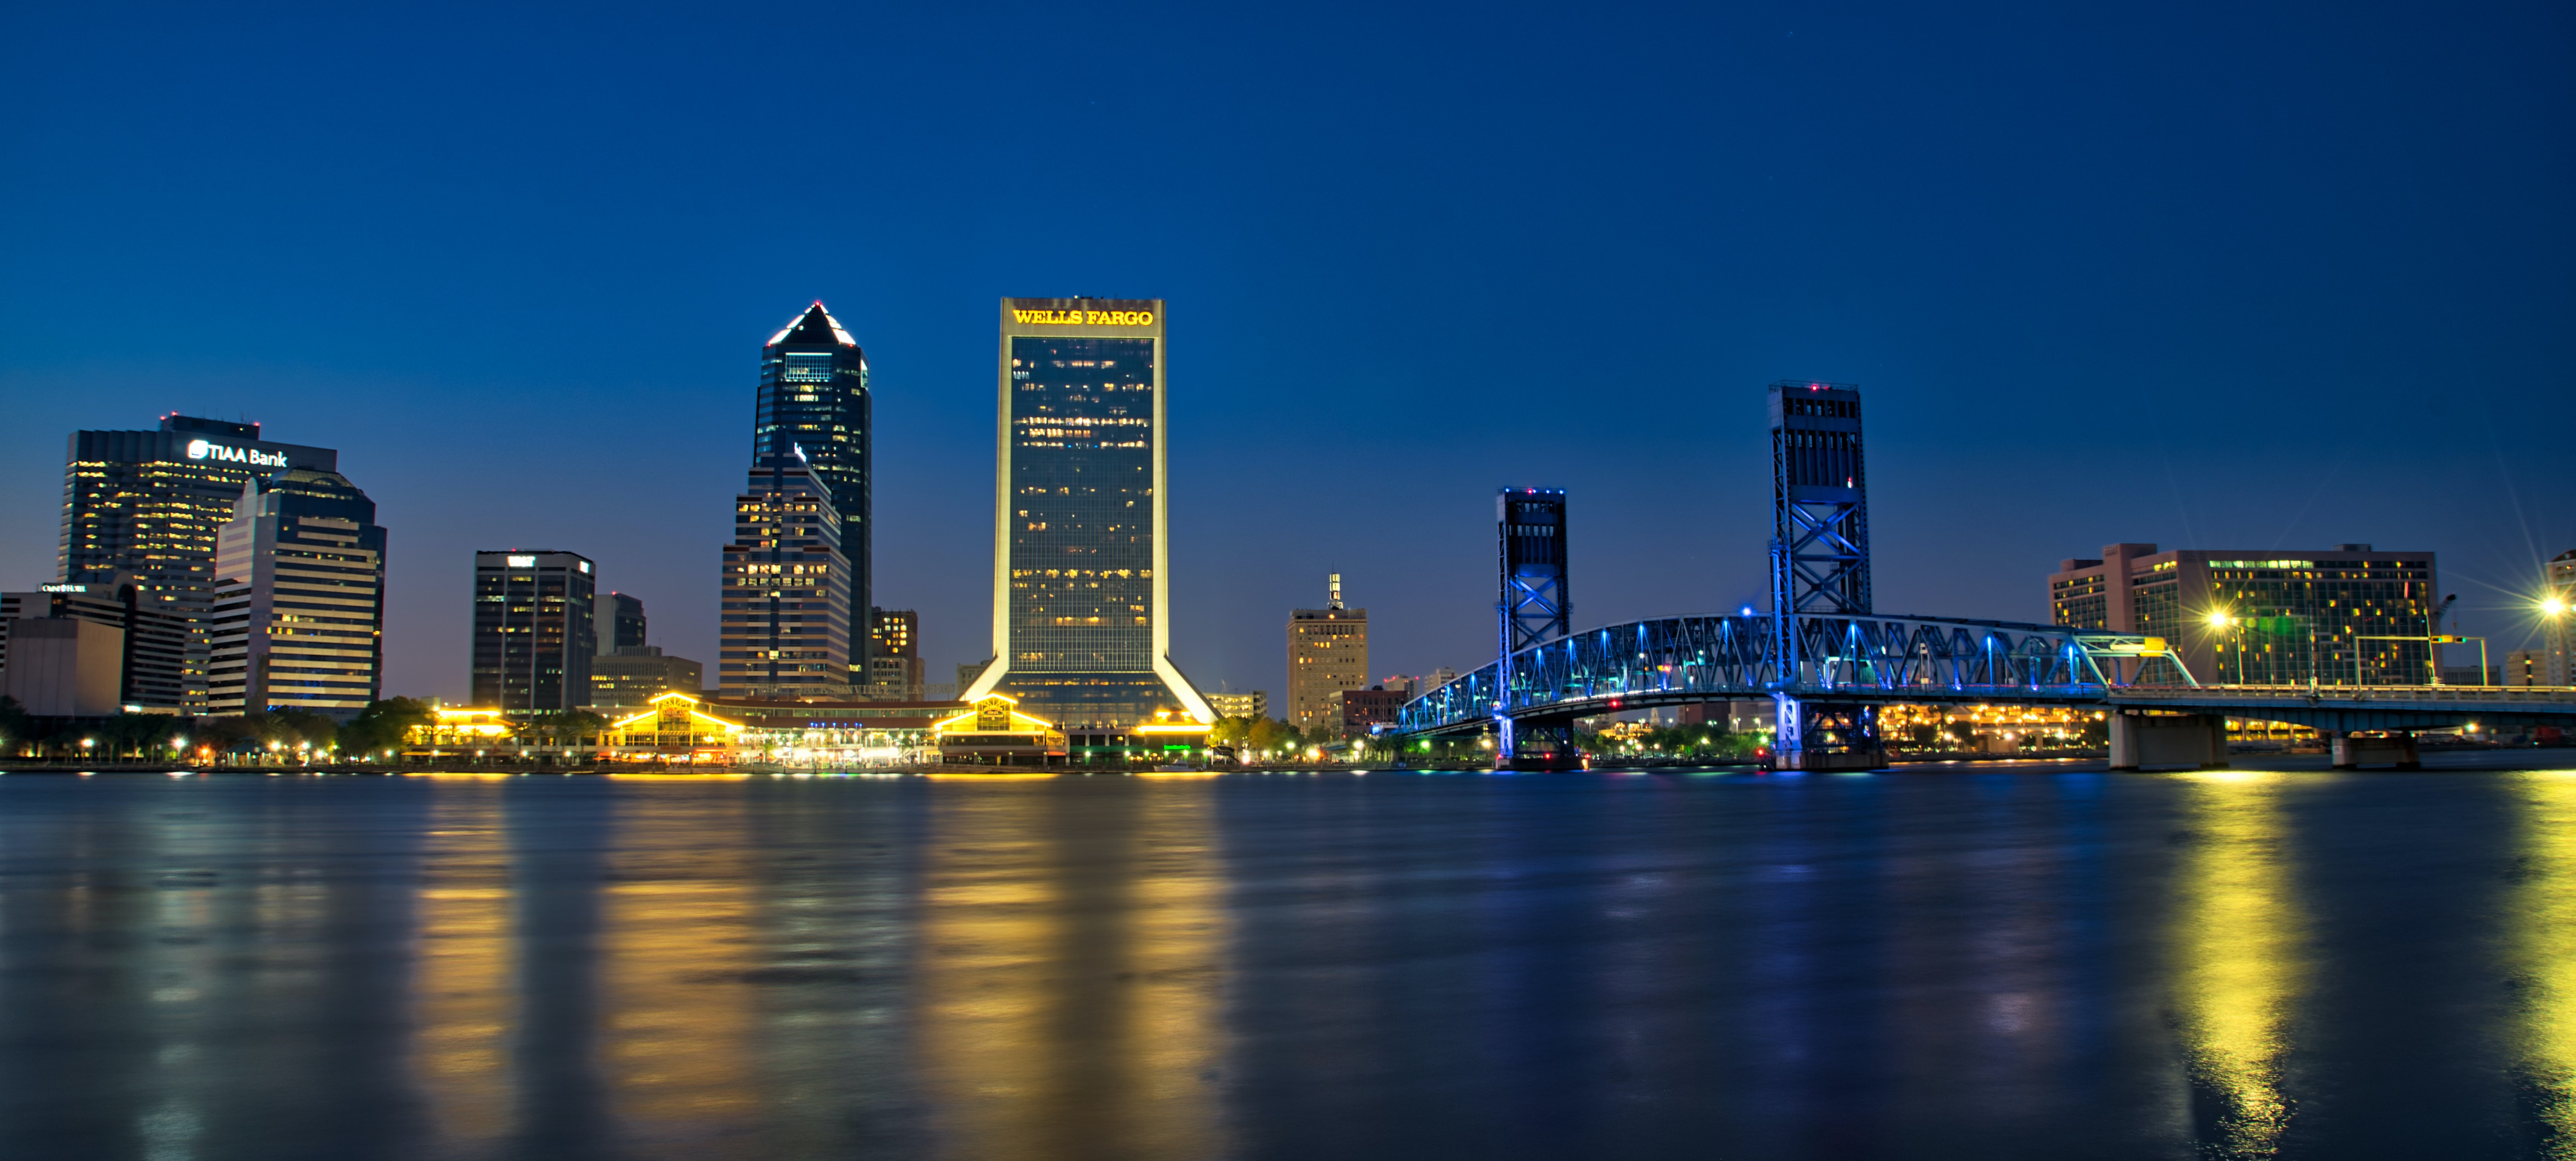

Photo by <a href="https://unsplash.com/pt-br/@encode?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Sean Burgess</a> on <a href="https://unsplash.com/photos/zNrZ12BfSUU?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

## Project Goal:

The goal of this project is to use time series data from Zillow to forecast home prices in Jacksonville, Fl. I will take the role of an analyst for a real estate consulting agency. The agency specializes in helping clients relocate in a relatively short time frame. The current client I am working with is a contractor who just agreed to a 2-year contract with a company based in Jacksonville, Fl.

The contract starts in 3 months, so the client would like to be in their new home by that time. They have a budget of $275,000. Additionally, there is a chance that they will be relocating again at the end of the current contract, so they would like to buy a home that will offer the best ROI if they need to sell it in 2 years time. My job is to help narrow the search by identifying zip codes in the Jacksonville area that meet the clients criteria. Once this is done, the client can make an informed choice while considering other options (commute time, neighborhood, convenience, etc.).

## Table of Contents

- [Understanding the Data](#Understanding-the-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Time Series Analysis](#Time-Series-Analysis)
    - [Model Building](#Model-Building)
        - [Train-Test Split](#Train-Test-Split)
    - [Model Forecasting](#Model-Forecasting)
    - [Forecasting Every Zip Code](#Forecasting-Every-Zip-Code)
- [Results](#Results)
- [Final Recommendation](#Final-Recommendation)
- [Appendix](#Appendix)
    - [Additional Data](#Additional-Data)
    - [Economic Conditions](#Economic-Conditions)

## Understanding the Data

The main dataset is a collection of median housing prices from [Zillow](https://www.zillow.com/research/data/) dating back to 1996 and grouped by zip code. I will perform EDA and preprocess the data so that it is ready for time series analysis.

The data has been smoothed and the seasonality has been removed. This means the analysis will be simpler, but also means some information is lost. In the Appendix, I will use additional seasonal data from Zillow to demonstrate how a more nuanced analysis could be performed. Unfortunately, the seasonal data is not available by zip code, but it still offers some insight when forecasting future house prices.

## Exploratory Data Analysis

EDA will consist of visualizing the data and processing it so that time series analysis can be performed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import itertools
import json
import folium

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# ! pip install pmdarima
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# set global style
sns.set_theme()
rcParams['figure.figsize'] = 15, 8
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
# plt.rcParams['axes.xmargin'] = 0

In [2]:
# import Zillow dataset
df = pd.read_csv('data/zillow_monthly_zc_data.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,111025.364504,...,262174.177552,267031.277605,271167.441993,274949.991267,277857.050380,279379.374979,279571.703469,278978.533186,278001.127045,276453.815200
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,217709.460879,...,452790.345320,460467.367267,467482.802830,473572.893250,477267.065068,477984.861877,476524.002739,474871.543073,473490.978602,471547.993017
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,93297.846024,...,177893.551274,180425.647045,182618.423967,184808.073687,186768.821493,188315.027071,189360.332747,190107.287314,190872.067470,191400.577159
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,75454.474440,...,336045.570757,336639.762806,336736.022093,337304.550369,337577.574287,336818.929821,335031.093053,333107.358734,332435.128586,331124.345954
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,237548.770794,...,740994.162841,743614.071840,750129.456105,757964.299916,763316.251684,764586.578334,761489.401151,758818.529559,756929.158762,753410.376751


The zip codes are located in the `RegionName` column. I will limit the data to only include entries from the Jacksonville Metropolitan Region, which contains all the zip codes in the greater Jacksonville area. The data is also in a wide format, so I will need to put it in long format before conducting any time series analysis.

In [3]:
jax_df = df[df['Metro'] == 'Jacksonville, FL']
jax_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
380,71864,380,32210,zip,FL,FL,Jacksonville,"Jacksonville, FL",Duval County,69931.644056,...,213807.843478,219203.259154,222868.350154,225897.424598,228304.718555,230080.427151,230982.966060,231482.418173,231812.256031,231340.212607
435,71871,435,32218,zip,FL,FL,Jacksonville,"Jacksonville, FL",Duval County,103268.670098,...,279694.457907,286657.471292,292152.483149,296812.636845,300118.332229,302231.540670,303157.381497,303736.444748,304116.504572,303422.475127
460,71895,460,32244,zip,FL,FL,Jacksonville,"Jacksonville, FL",Duval County,82775.997343,...,247207.484977,253428.261759,258101.406082,261730.442063,264287.719666,265965.536829,266647.719598,266766.765711,266512.717562,265413.870496
500,71768,500,32068,zip,FL,FL,Middleburg,"Jacksonville, FL",Clay County,100998.911286,...,312774.489266,319499.346709,324891.195896,329394.117639,332233.959050,333620.954079,333263.989204,332259.186615,330989.643463,329275.923272
609,71878,609,32225,zip,FL,FL,Jacksonville,"Jacksonville, FL",Duval County,118861.080522,...,343776.456204,350973.379412,356141.299618,360151.561216,362653.150493,363772.543784,363813.381022,363787.387409,363816.438203,362964.680817


In [4]:
id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']

def aggregate_city_data(df):
    '''
    Aggregate all the data for the Jacksonville area
    and convert it from wide to long format.
    '''
    melted = pd.melt(df,
                     id_vars=id_vars,
                     var_name='time')
    
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    
    return melted.groupby('time').aggregate({'value':'mean'})

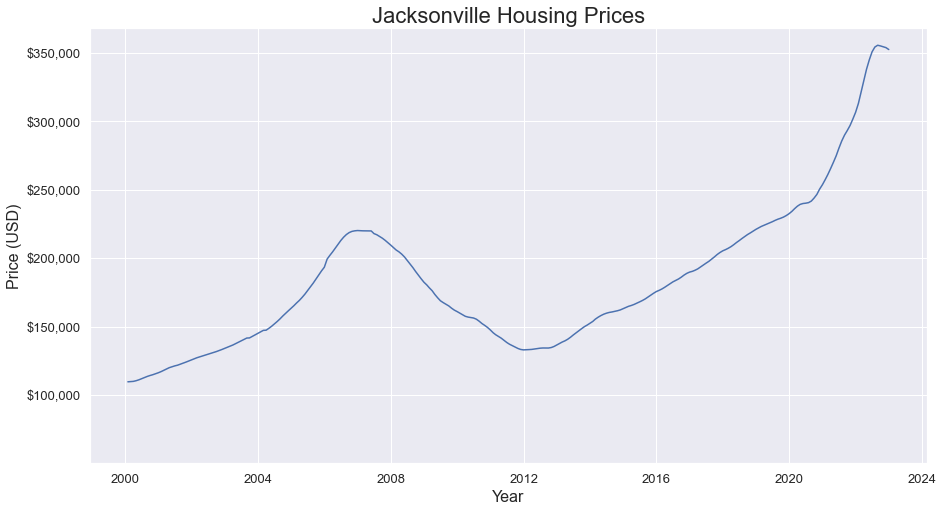

In [5]:
# create Jacksonville time series
jax_ts = aggregate_city_data(jax_df)

# plot Jacksonville data
fig,ax = plt.subplots()

ax.plot(jax_ts)
ax.set_title('Jacksonville Housing Prices')
ax.set_ylabel('Price (USD)')
ax.set_xlabel('Year')
ax.set_yticks(ax.get_yticks()[:-1])
ax.set_yticklabels(['', '$100,000', '$150,000', '$200,000', '$250,000', '$300,000', '$350,000'])

plt.savefig('graphs/jax_avg_housing_prices.png', bbox_inches='tight');

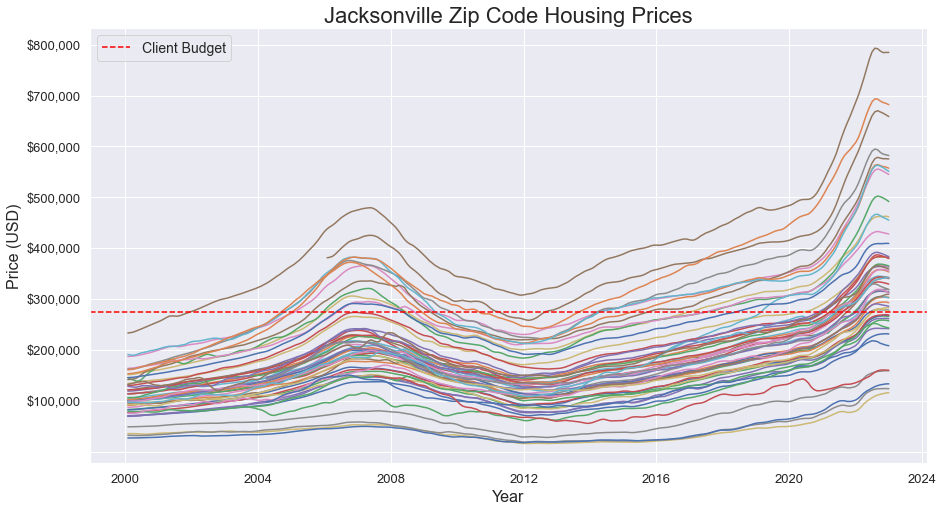

In [6]:
# create lists to hold zip codes and corresponding time series
loc_list = []
ts_list = []

# create seperate time series for each zip code in Jacksonville
for region in jax_df['RegionName'].unique():
    
    init_df = jax_df[jax_df['RegionName'] == region]
    
    # wide to long format
    melted_df = pd.melt(init_df, id_vars=id_vars, var_name='time', value_name='price')
    melted_df['time'] = pd.to_datetime(melted_df['time'], infer_datetime_format=True)
    
    df = melted_df.drop(id_vars, axis=1)
    df.set_index('time', inplace=True)
    
    # add zip code and time series to lists
    loc_list.append(region)
    ts_list.append(df)  

fig,ax = plt.subplots()
# plot price data for each zip code
for zip_code in ts_list:
    ax.plot(zip_code)

# plot client budget
ax.axhline(y=275000, c='red', label='Client Budget', linestyle='--')

ax.set_title('Jacksonville Zip Code Housing Prices')
ax.set_ylabel('Price (USD)')
ax.set_xlabel('Year')
ax.legend(loc=2, fontsize=14)
ax.set_yticks(ax.get_yticks()[1:-1])
ax.set_yticklabels(['', '$100,000', '$200,000', '$300,000', '$400,000', '$500,000', '$600,000', '$700,000', '$800,000'])

plt.savefig('graphs/jax_zc_housing_prices.png', bbox_inches='tight');

We can see a fairly consistent pattern acros each zip code, though some seem to be growing faster than others. After discussing a budget range with the client, I will limit the zip codes to those with a current median price between 200,000 and 300,000.

In [7]:
budget_ts = []
budget_loc = []

# keep zip codes that are within budget range
for idx in range(len(ts_list)):
    if 200000 <= float(ts_list[idx].iloc[-1]) <= 300000:
        budget_ts.append(ts_list[idx])
        budget_loc.append(loc_list[idx])
        
for ts in budget_ts:
    ts.dropna(inplace=True)

In [8]:
# current median price in each zip code
current_prices = [float(ts.iloc[-1]) for ts in budget_ts]
current_prices_sorted = sorted(zip(current_prices, budget_loc))
current_prices_sorted

[(208151.0629042606, 32087),
 (231340.2126068994, 32210),
 (241594.57740766823, 32211),
 (243086.1759607381, 32145),
 (257090.0376046557, 32656),
 (261167.54079645488, 32205),
 (265413.87049580755, 32244),
 (267611.933646926, 32216),
 (268455.21375983354, 32207),
 (276510.4214166018, 32666),
 (277733.4062595222, 32277),
 (282548.35287346854, 32219),
 (285851.6218673427, 32063),
 (292784.5902438749, 32220)]

In [9]:
# corresponding zip codes and current median prices
zip_codes = [zip_code for _, zip_code in current_prices_sorted]
prices = [price for price, _ in current_prices_sorted]

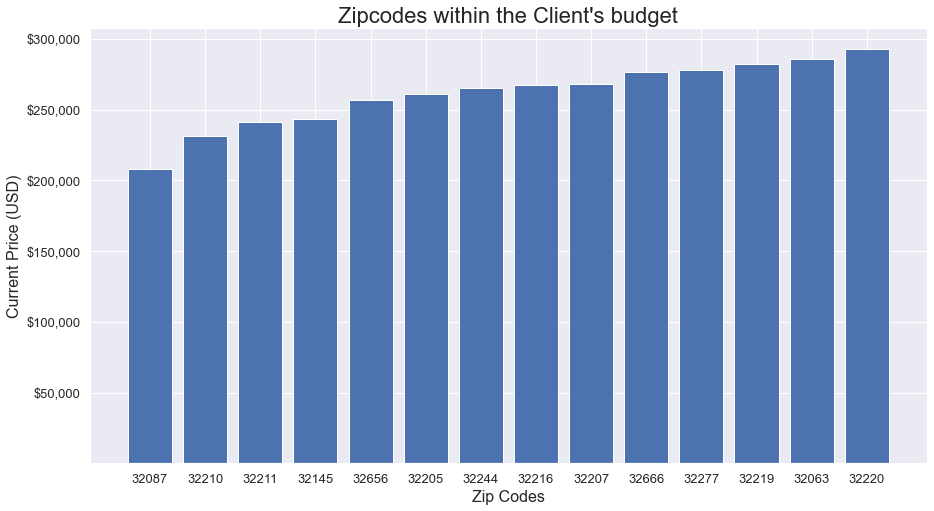

In [10]:
fig,ax = plt.subplots()
# plot current median prices
ax.bar(x=range(len(prices)), height=prices)

ax.set_xticks(range(len(prices)))
ax.set_xticklabels(zip_codes, fontsize=13)
ax.set_title("Zipcodes within the Client's budget")
ax.set_ylabel("Current Price (USD)")
ax.set_xlabel("Zip Codes")
ax.set_yticks(ax.get_yticks()[:-1])
ax.set_yticklabels(['', '$50,000', '$100,000', '$150,000', '$200,000', '$250,000', '$300,000'])

plt.savefig('graphs/zc_current_price.png', bbox_inches='tight');

In [11]:
# calculate 3 and 6 year roi
roi_3_yr = [float((ts.loc['2022-12-31'] - ts.loc['2020-01-31']) / ts.loc['2020-01-31']) for ts in budget_ts]
roi_6_yr = [float((ts.loc['2022-12-31'] - ts.loc['2017-01-31']) / ts.loc['2017-01-31']) for ts in budget_ts]

In [12]:
zips_6 = [zip_code for _, _, zip_code in sorted(zip(roi_6_yr, roi_3_yr, budget_loc))]
roi_6 = [roi for roi, _, _ in sorted(zip(roi_6_yr, roi_3_yr, budget_loc))]
roi_3 = [roi for _, roi, _ in sorted(zip(roi_6_yr, roi_3_yr, budget_loc))]

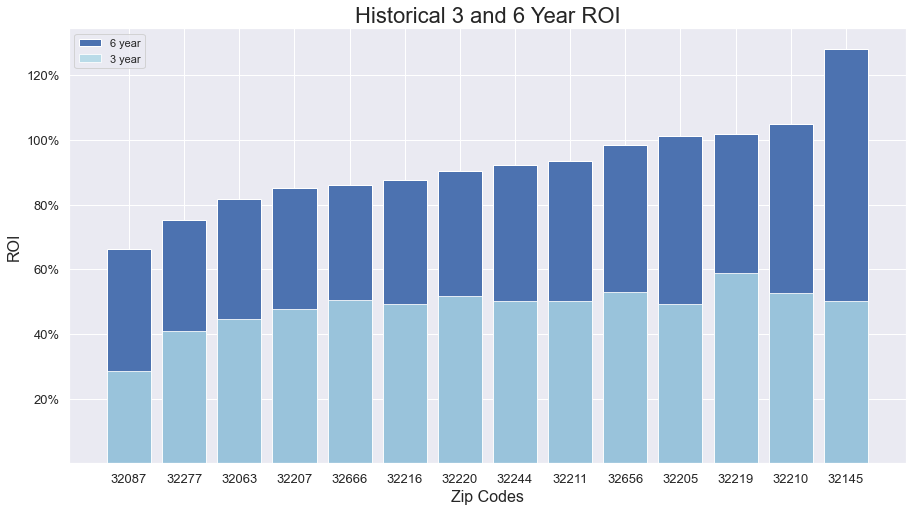

In [13]:
fig,ax = plt.subplots()

# plot 6 year roi
ax.bar(x=range(len(roi_6)), height=roi_6, label='6 year')
#plot 3 year roi
ax.bar(x=range(len(roi_3)), height=roi_3, label='3 year', color='lightblue', alpha=.8)

ax.set_xticks(range(len(roi_6)))
ax.set_xticklabels(zips_6, fontsize=13)
ax.set_title("Historical 3 and 6 Year ROI",)
ax.set_ylabel("ROI")
ax.set_xlabel("Zip Codes")
ax.legend()
ax.set_yticks(ax.get_yticks()[:-1])
ax.set_yticklabels(['', '20%', '40%', '60%', '80%', '100%', '120%'])

plt.savefig('graphs/past_roi_3_and_6.png', bbox_inches='tight');

## Time Series Analysis

Now that I have examined historic housing prices, I will turn to creating a time series model. To do so, I will use the Dickey-Fuller test as a metric for determining the stationarity of the data, which is needed if I am to perform time series analysis. I will then need to determine the optimal order of the auto-regression(AR) and moving average(MA).

I will build an initial model using the Jacksonville average time series data, then repeat the process for each zip code. I can then forecast the price in 2 years and calculate the ROI for each zip code.

In [14]:
def dickey_fuller(ts, prnt=True):
    '''
    Create a dataframe with the results of the Dickey-Fuller Test.
    ---
    Input:
    
    ts: time series to be evaluated
    prnt: print results if True, else returns the p-value
    '''
    # perform dickey-fuller test
    dickey = adfuller(ts)
    
    if prnt:
        results = pd.Series(dickey[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
        for key,value in dickey[4].items():
            results['Critical Value (%s)'%key] = value
            
        print('Results of Dickey-Fuller Test: \n')
        print(results)
        
    else:
        # p-value
        return dickey[1]

In [15]:
# test stationarity of the time series
dickey_fuller(jax_ts)

Results of Dickey-Fuller Test: 

Test Statistic                  -0.817756
p-value                          0.813851
#Lags Used                       3.000000
Number of Observations Used    272.000000
Critical Value (1%)             -3.454622
Critical Value (5%)             -2.872225
Critical Value (10%)            -2.572464
dtype: float64


A p-value of 0.81 suggests that the data is non-stationary. Since the seasonality has already been smoothed, I can focus on de-trending the data. One way is to perform differencing, which creates a new time series that is takes the difference between each data point and the previous data point.

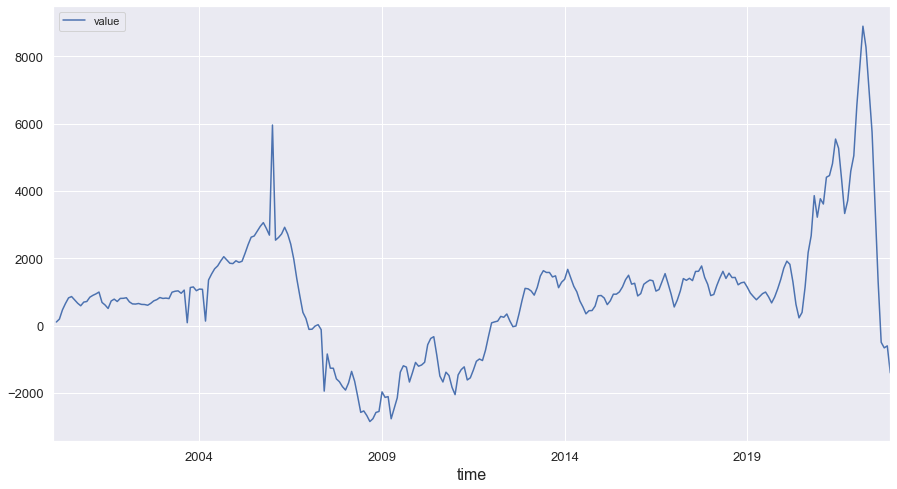

In [16]:
# difference and plot the resulting data
jax_diff = jax_ts.diff()
jax_diff.plot();

In [17]:
dickey_fuller(jax_diff.dropna())

Results of Dickey-Fuller Test: 

Test Statistic                  -3.888617
p-value                          0.002120
#Lags Used                      16.000000
Number of Observations Used    258.000000
Critical Value (1%)             -3.455953
Critical Value (5%)             -2.872809
Critical Value (10%)            -2.572775
dtype: float64


The drop in p-value from 0.813 to 0.002 suggests that the data has been successfully de-trended. This does not mean that I am done, as I still need to see what degree of AR and MA might further improve the model, but it does mean that I will need to difference the data.

#### Train-Test Split

In order to train the model, I will use a train-test split of 80-20, starting from 2012. This is because this timeframe best captures the current state of the housing market. Prior to 2012, the housing market was tumultous due to the global financial crisis and housing bubble in 2008.

The choice of split is also especially important with the current dataset because of the change in behavior starting from around 2021. After this point in time, the housing prices begin to increase at a much faster rate before flattening out in the last few months. There are several factors for this, but the biggest one is the effect of the COVID pandemic and the resulting economic policies such as a drastic and long laasting reduction in the interest rate, which contributed to a rapid rise in house prices.

By training a model on pre-pandemic data, it is almost guaranteed to struggle at accounting for the change in price growth in the test set. Ultimately, I have decided to still create a model based on the training set because I believe that data is more indicative of the long term housing price growth, and as I will demonstrate in the Appendix, it appears that the market is undergoing a correction that will return it to pre-pandemic levels.

This decision will have implications for which model parameters I ultimately use, but should still provide good comparative metrics for the client to make an informed choice.

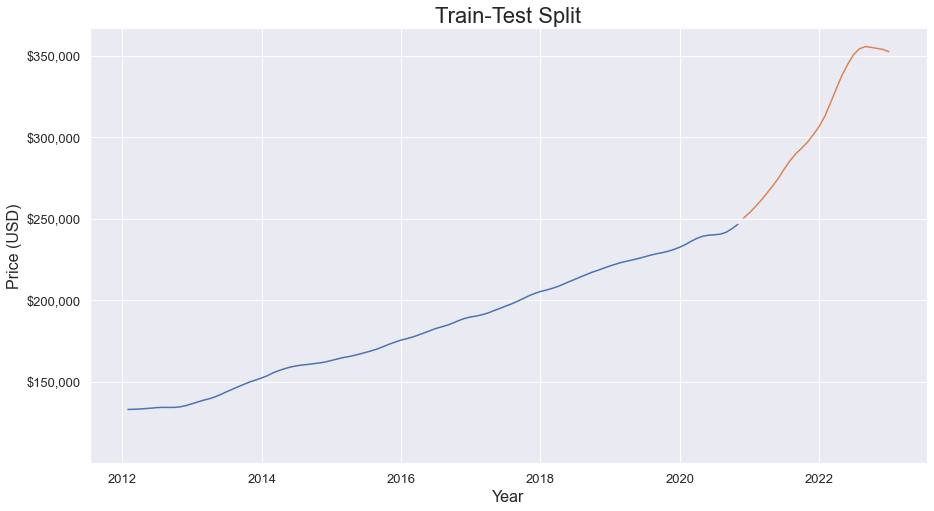

In [18]:
X = jax_ts['2012-01-31':]

# set train-test split
cutoff = round(X.shape[0]*0.8)
train = X[:cutoff]
test = X[cutoff:]

fig,ax = plt.subplots()

ax.plot(train)
ax.plot(test)

ax.set_title('Train-Test Split')
ax.set_ylabel('Price (USD)')
ax.set_xlabel('Year')
ax.set_yticks(ax.get_yticks()[:-1])
ax.set_yticklabels(['', '$150,000', '$200,000', '$250,000', '$300,000', '$350,000'])

plt.savefig('graphs/train_test_split.png', bbox_inches='tight');

I will use `auto_arima` to determine the optimal parameters by comparing AIC scores. The documentation for `auto_arima` can be found [here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html).

In [19]:
model = auto_arima(train,
                   start_p=0,
                   start_q=0,
                   test='adf',
                   max_p=5,
                   max_q=5,
                   m=1,
                   d=None, # set to None to find the best order of differencing
                   seasonal=False,
                   trace=True,
                   stepwise=True,
                   with_intercept=False
                  )

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1447.524, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1446.984, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1446.937, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1448.929, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1448.916, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1446.982, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1447.661, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.476 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  106
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -721.469
Date:                Mon, 27 Mar 2023   AIC                           1446.937
Time:                        15:08:57   BIC                           1452.226
Sample:                

The result was an order of (0,2,1). The result is slightly non-normal, as indicated by the Jarque-Bera score, but it is the model with the highest AIC. I will use this to fit an arima model and examine the diagnostics.

In [20]:
ARIMA_MODEL = ARIMA(train,
                    order=(0,2,1),
                    seasonal_order=(0,0,0,0), 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)

output = ARIMA_MODEL.fit()

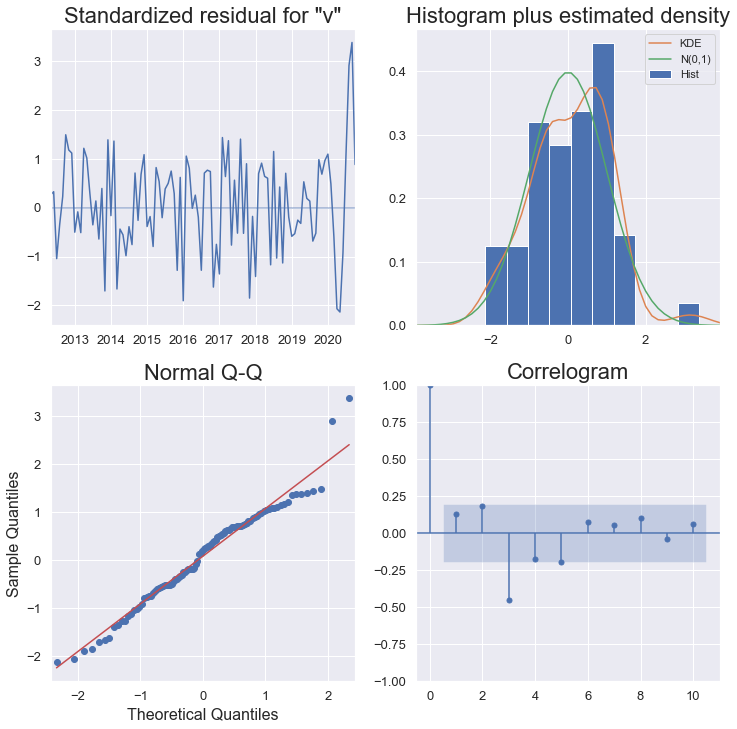

In [21]:
output.plot_diagnostics(figsize=(12, 12))

plt.savefig('graphs/train_model_diag.png', bbox_inches='tight');

The diagnostics look good, with the exception of the change in residuals and deviation from the Q-Q plot at the tail-end of the data. As expected, the data is also somewhat non-normal. I will use this model to get predictions on the test set to evaluate the model.

In [22]:
pred = output.get_prediction(start=pd.to_datetime('2020-10-31'), end=pd.to_datetime('2022-12-31'), dynamic=False)
pred_conf = pred.conf_int()

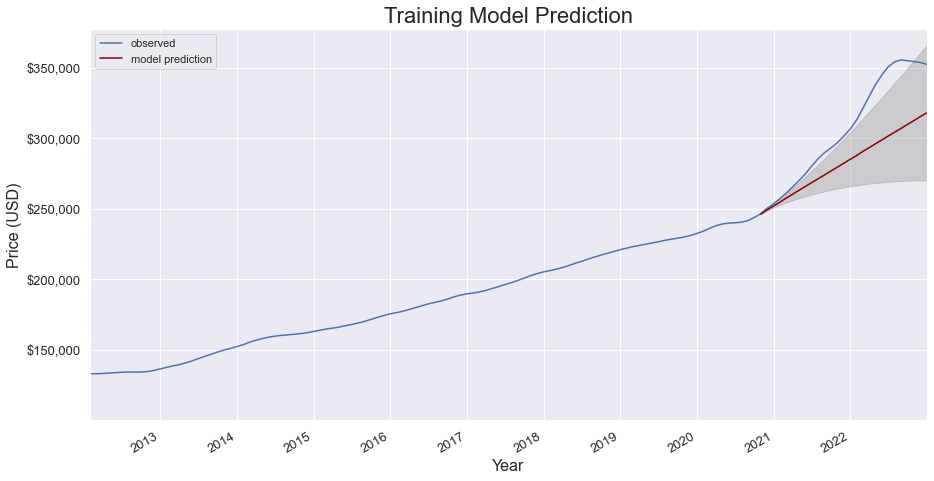

In [23]:
fig,ax = plt.subplots()

# plot observed values
ax.plot(X, label='observed')

# plot predicted values
pred.predicted_mean.plot(ax=ax, label='model prediction', color='darkred')

# plot the range for confidence intervals
ax.fill_between(pred_conf.index.values,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                color='grey',
                alpha=0.3)

# Set axes labels
ax.set_xlabel('Year')
ax.set_ylabel('Price (USD)')
ax.set_title('Training Model Prediction')
ax.set_xmargin(0)
plt.legend()
ax.set_yticks(ax.get_yticks()[:-1])
ax.set_yticklabels(['', '$150,000', '$200,000', '$250,000', '$300,000', '$350,000'])

plt.savefig('graphs/train_model_pred.png', bbox_inches='tight');

As expected, the model fails to account for the post-pandemic price boom. However, as outlined in the Appendix, I believe that the market is currently undergoing a correction, and will be returning to levels similar to the pre-pandemic data, so I will use these same parameters on the entire dataset and evaluate the results.

In [24]:
ARIMA_MODEL = ARIMA(X, # full dataset
                    order=(0,2,1), 
                    seasonal_order=(0,0,0,0), 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)

output = ARIMA_MODEL.fit()

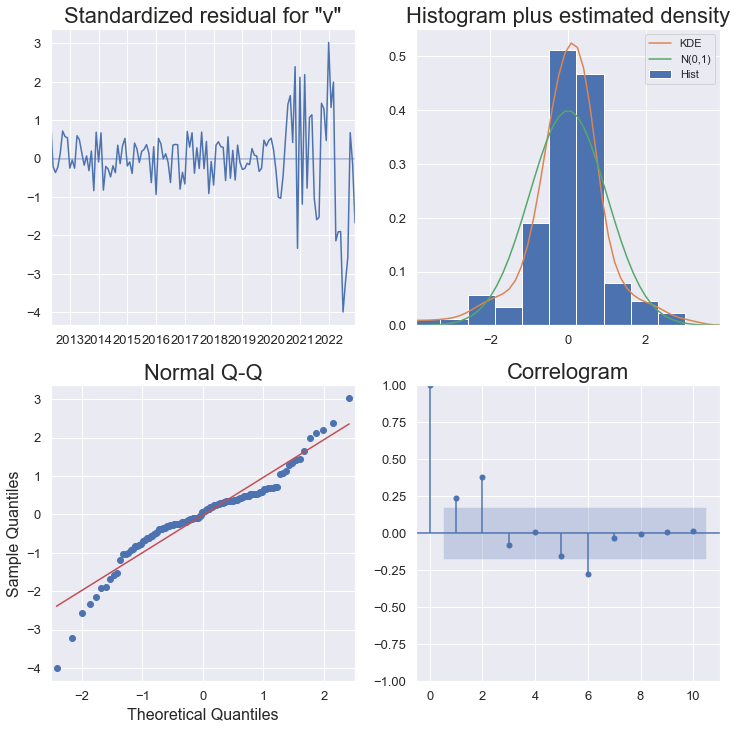

In [25]:
output.plot_diagnostics(figsize=(12, 12))

plt.savefig('graphs/X_model_diag.png', bbox_inches='tight');

Interestingly, the results are more normal than when performed on only the training data. There is still an issue with the increased distribution of residuals at the tail-end, along with deviation in the Q-Q plot and the correlogram. However, I believe this is still the best model to use moving forward.

### Model Forecasting

I will now use the model to forecast the change in price over the next 2 years. I can then use the predictions to calculate the 2-year roi forecast.

In [26]:
# forecast 2 years out
forecast = output.get_forecast(steps=24)

# get forecast confidence intervals
forecast_conf = forecast.conf_int()

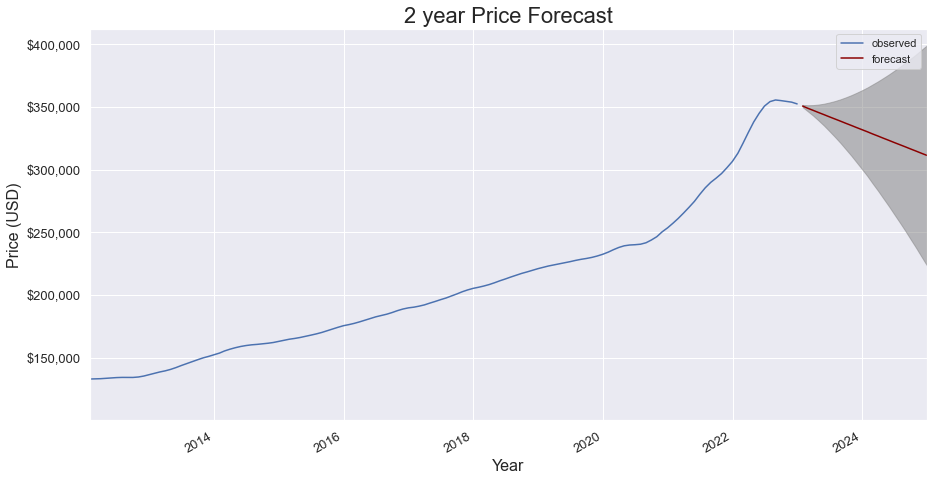

In [27]:
fig,ax = plt.subplots()

ax.plot(X, label='observed')

forecast.predicted_mean.plot(ax=ax, label='forecast', color='darkred')

ax.fill_between(forecast_conf.index.values,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1],
                color='grey',
                alpha=0.5)

ax.set_title('2 year Price Forecast')
ax.set_xlabel('Year')
ax.set_ylabel('Price (USD)')
ax.set_xmargin(0)
plt.legend()
ax.set_yticks(ax.get_yticks()[:-1])
ax.set_yticklabels(['', '$150,000', '$200,000', '$250,000', '$300,000', '$350,000', '$400,000'])

plt.savefig('graphs/jax_avg_forecast_2_yr.png', bbox_inches='tight');

### Forecasting Every Zip Code

Now that I have a method for determining a 2 year price forecast, I can repeat the process for each individual zip code in Jacksonville. I will use `auto-arima` on each training set to determine the optimal parameters, and then train a model using those parameters on the full dataset.

In [28]:
# forecast_rois = {}
fc_rois = []

# build a model for each zip code
for idx in range(len(budget_ts)):
    
    X = budget_ts[idx]['2012-01-31':]
    cutoff = round(X.shape[0]*0.8)

    train = X[:cutoff]
    test = X[cutoff:]
    
    # find optimal parameters
    model = auto_arima(train,
                       start_p=0,
                       start_q=0,
                       test='adf',
                       max_p=5,
                       max_q=5,
                       m=1,
                       d=2,
                       seasonal=False,
                       trace=False,
                       stepwise=True,
                       with_intercept=False)
    
    # build the model
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(X,
                                            order= model.order, 
                                            seasonal_order= model.seasonal_order, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)
    
    output = ARIMA_MODEL.fit()
    
    # 2 year forecast
    forecast = output.get_forecast(24)
    forecast_conf = forecast.conf_int()
    forecast_conf['pred'] = forecast.predicted_mean
    
    # calculate future 2-year roi based on forecast
    future_roi = ((forecast_conf['pred'][-1]) - (X['price'][-1])) / (X['price'][-1])
    
    fc_rois.append(future_roi)

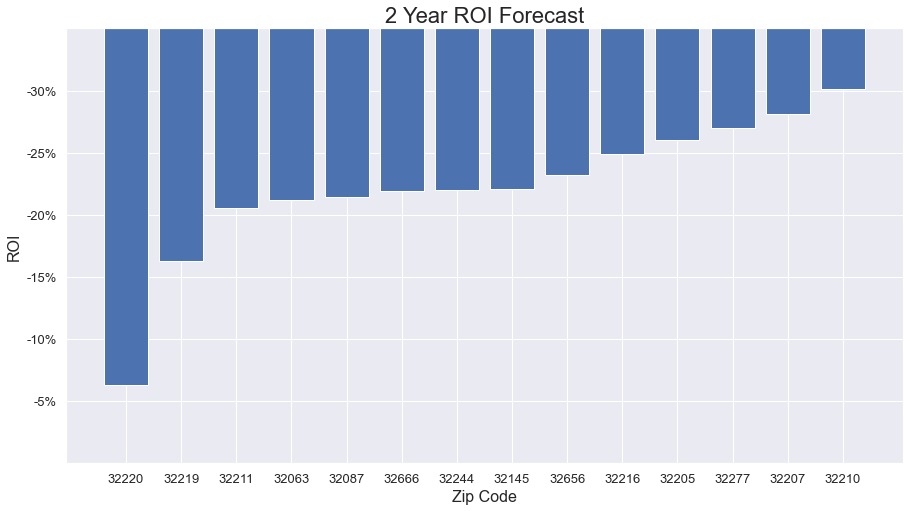

In [29]:
roi_zips = [zip_code for _, zip_code in sorted(zip(fc_rois, budget_loc))]
roi_totals = [roi for roi, _ in sorted(zip(fc_rois, budget_loc))]

fig,ax = plt.subplots()
# plot roi forecast
ax.bar(x=range(len(roi_totals)), height=roi_totals)

ax.set_xticks(range(len(roi_zips)))
ax.set_xticklabels(roi_zips, fontsize=13)
ax.set_title("2 Year ROI Forecast")
ax.set_ylabel("ROI")
ax.set_xlabel("Zip Code")
ax.set_yticks(ax.get_yticks()[:-1])
ax.set_yticklabels(['', '-5%', '-10%', '-15%', '-20%', '-25%', '-30%'])

plt.savefig('graphs/zc_forecasts.png', bbox_inches='tight');

## Results

It appears that all the models are predicting a drop in price over the next 2 years. While I suspect that the drop in prices may not hold for the full 2 years, the predictions provide the metric I need to make a recommendation to the client about which zip code to look for a suitable house.

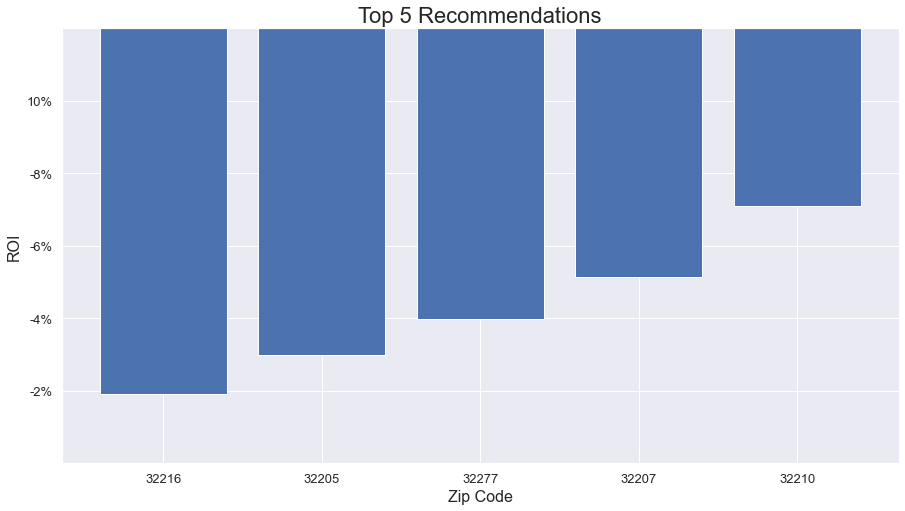

In [30]:
# top 5 recommendations
top_5_zips = roi_zips[-5:]
top_5_roi = roi_totals[-5:]

fig,ax = plt.subplots()
# plot top 5 zip codes rois
ax.bar(x=range(len(top_5_roi)), height=top_5_roi)

ax.set_xticks(range(len(top_5_zips)))
ax.set_xticklabels(top_5_zips,fontsize='13')
ax.set_title('Top 5 Recommendations')
ax.set_ylabel('ROI')
ax.set_xlabel('Zip Code')
ax.set_yticks(ax.get_yticks()[:-1])
ax.set_yticklabels(['', '-2%', '-4%', '-6%', '-8%', '10%'])

plt.savefig('graphs/zc_recommendations.png', bbox_inches='tight');

Now that I have the final recommendations, I can proceed to the next step in the process with the client as they continue their search. Below is a map of the recommended zip codes.

In order to create the highlighted zip codes, I need geojson data for Florida zip codes. The data I use can be found [here](https://github.com/OpenDataDE/State-zip-code-GeoJSON).

In [31]:
# load Florida zip code geojson data
f = open('data/fl_florida_zip_codes_geo.min.json')
data = json.load(f)

# new dictionary for Jacksonville zip code data
jax_dict = {'features':[]}

# include data from each recommended zip code
for dictionary in data['features'][:]:
    # 'ZCTA5CE10' contains the zip code
    if int(dictionary['properties']['ZCTA5CE10']) in top_5_zips:
        jax_dict['features'].append(dictionary)


In [32]:
# create Jacksonville map
m = folium.Map(location=[30.3322, -81.6557])

# add geojson layer to highlight each zip code
folium.GeoJson(data=(jax_dict), name='layerName').add_to(m)

marker_colors=['red', 'blue', 'green', 'purple', 'orange']

for idx in range(len(jax_dict['features'])):
    
    # central lat, long, and name of each zip code
    lat = jax_dict['features'][idx]['properties']['INTPTLAT10']
    long = jax_dict['features'][idx]['properties']['INTPTLON10']
    zc = jax_dict['features'][idx]['properties']['ZCTA5CE10']
    
    #add markers at the center of each zip code
    folium.Marker(location=[lat, long],
                  popup=zc,
                  tooltip=zc,
                  icon=folium.Icon(color=marker_colors[idx], icon='glyphicon-map-marker')
                 ).add_to(m)

m

## Final Recommendation

Given the available data, I was able to compare the expected 2-year ROI for house prices in each zip code in Jacksonville, Fl. Using the budget from my client, I selected the top 5 zip codes that offer the best ROI. From there, I can narrow the search as I continue to work with the client to get them successfully relocated within the timeframe.

## Appendix

The models built above show a decrease in house prices for all zip codes. The drop in price will likely continue in the near future, but it is almost certain that prices will rebound at some point and continue rising once again. The models, being univariate, have no reliable way to predict when that rebound might occur. In this appendix, I will examine some of the other factors to consider, and how they might be incorporated into a more nuanced analysis if there was more data available.

As noted previously, the data used above is smoothed and the seasonality has been removed. While helpful in simplying the analysis, having access to seasonal data can provide more immediate information that can inform forecasts. Unfortunately, the seasonal data is not available at a zip code level. There are also a number of other datasets available from Zillow that include things like the average days pending for each home sale. However, this data only goes back to 2018, and is also not available at a zip code level.

This additional data could be useful in predicting changes in housing prices, but due to the scope of the data, any contributions it could make are greatly reduced. Because of this, I will instead demonstrate how the data could be incorporated to create a more nuanced analysis if more data was available. 

In [33]:
# only keep US data for demonstration purposes
us_dfs = []

def preprocess_data(df, id_vars, value_name):
    '''
    Prepare and split data for time series analysis.
    
    The raw national data from https://www.zillow.com/research/data/ is in wide format.
    This function then puts the data in long format so time series analysis can be performed.
    Then it creates a new dataframe with only the relevant data (US), and puts it into a list.
    ---
    Input:
    
    df: a dataframe from csv from https://www.zillow.com/research/data/
    id_vars: all column names except the columns to be melted.
    value_name: name of the new long-format value.
    ---
    Output:
    
    The resulting dataframe.
    '''
    # wide to long format
    data = pd.melt(df, id_vars=id_vars, var_name='time', value_name=value_name)
    
    # only keep US data
    us_data = data[data['RegionName'] == 'United States']
    
    #set datetime
    us_data['time'] = pd.to_datetime(us_data['time'], infer_datetime_format=True)
    
    # drop everything except time series data
    us_data.drop(id_vars, axis=1, inplace=True)
    us_data.set_index('time', inplace=True)
    
    us_dfs.append(us_data)

In [34]:
# csv files to import 
source_names = ['data/Metro_invt_fs_all home_month.csv',
              'data/Metro_med_doz_pending_all_home_month.csv',
              'data/Metro_median_days_to_close_all_home_month.csv',
              'data/Metro_median_sale_price_all_home_month.csv',
              'data/Metro_median_sale_to_list_all_home_month.csv',
              'data/Metro_new_listings_all_home_month.csv']

value_names = ['forsale_inv',
               'median_days_pending',
               'median_days_to_close',
               'median_sale_price',
               'median_sale_to_list_ratio',
               'new_listings']

id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']

data_list = [pd.read_csv(file) for file in source_names]

for i in range(len(value_names)):
    preprocess_data(df=data_list[i], id_vars=id_vars, value_name=value_names[i])

### Additional Data

Now that the data has been processed, I can take a look at the different time series:

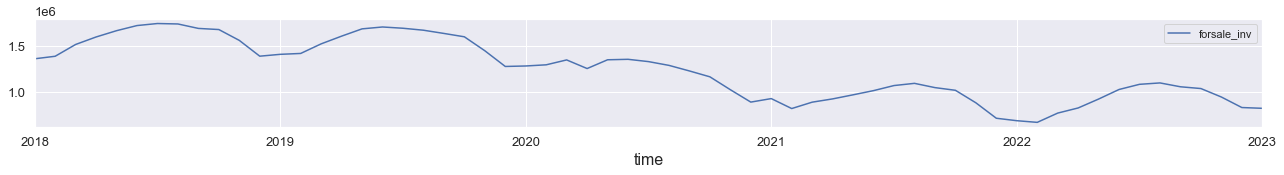

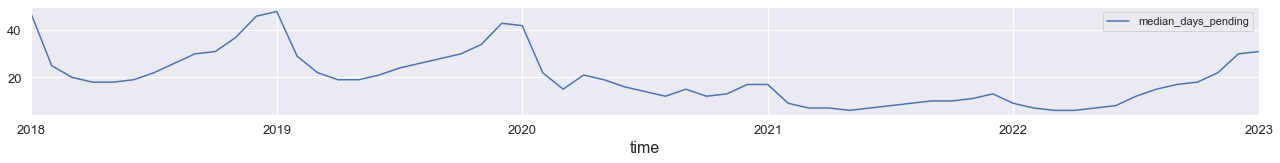

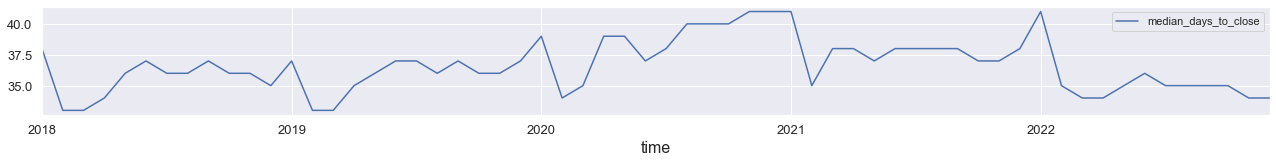

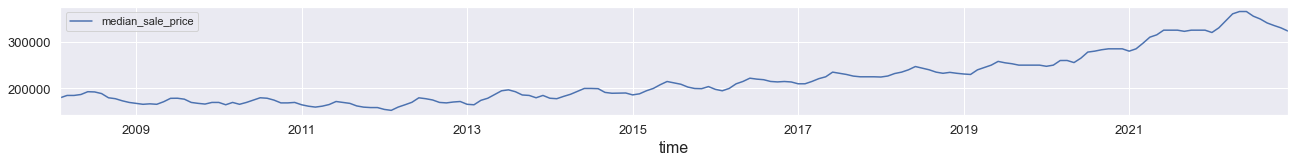

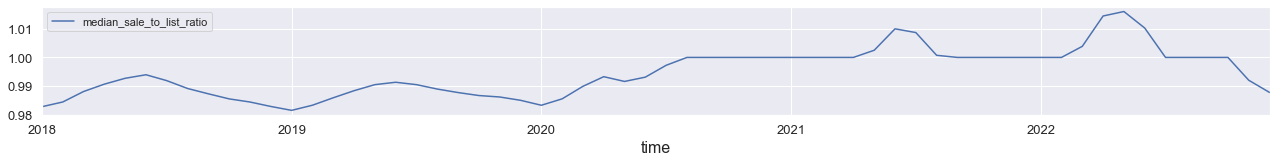

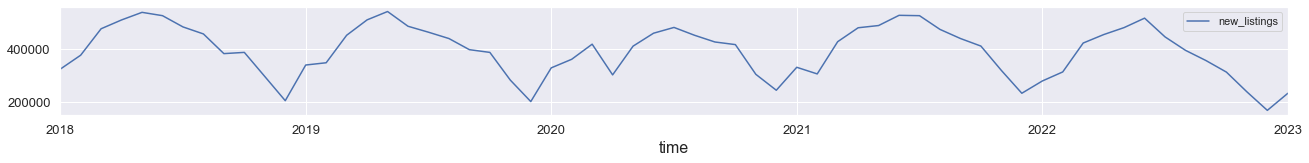

In [35]:
for df in us_dfs:    
    df.plot(figsize=(22,2));

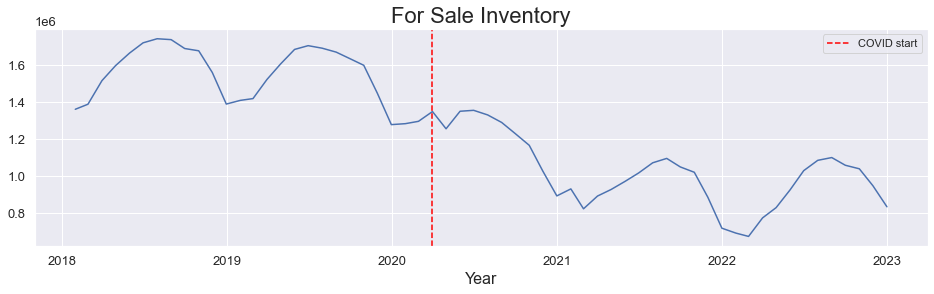

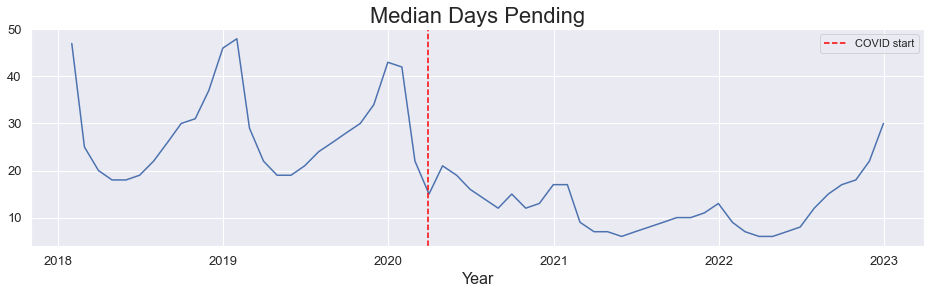

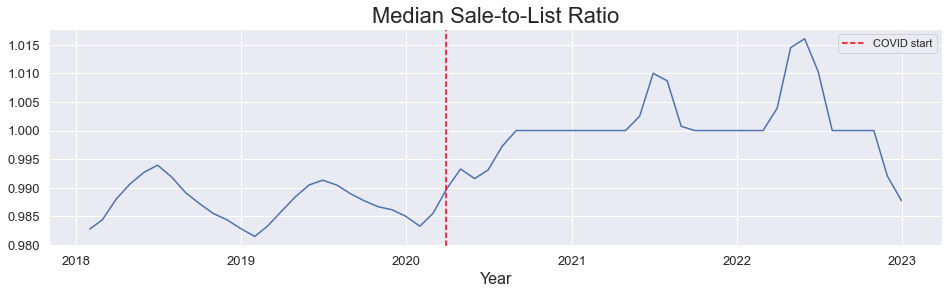

In [37]:
supp_dfs = [us_dfs[0], us_dfs[1], us_dfs[4]]

titles = ['For Sale Inventory', 'Median Days Pending', 'Median Sale-to-List Ratio']

for idx in range(len(supp_dfs)):
    
    df = supp_dfs[idx]
    df = df['2018-01-31':'2022-12-31']
    
    fig, ax = plt.subplots(figsize=(16,4))
    
    ax.plot(df)
    ax.set_title(titles[idx])
    ax.set_xlabel('Year')
    ax.axvline(x=18350, c='red', label='COVID start', linestyle='--')
    ax.legend()
    plt.savefig(f'graphs/supp_data_{idx}.png', bbox_inches='tight')

As noted earlier, all the datasets except for `median_sale_price` only go back to 2018. Despite the short time frame, there is evidence of stationary seasonal patterns in several of the datasets, but most of them only last from 2018-2020. With the exception of `new_listings`, the patterns are disrupted after 2020. This is likely due to the effect that the pandemic had on the housing market, and is something we also saw in the `median_sale_price`, which I will show once again here:

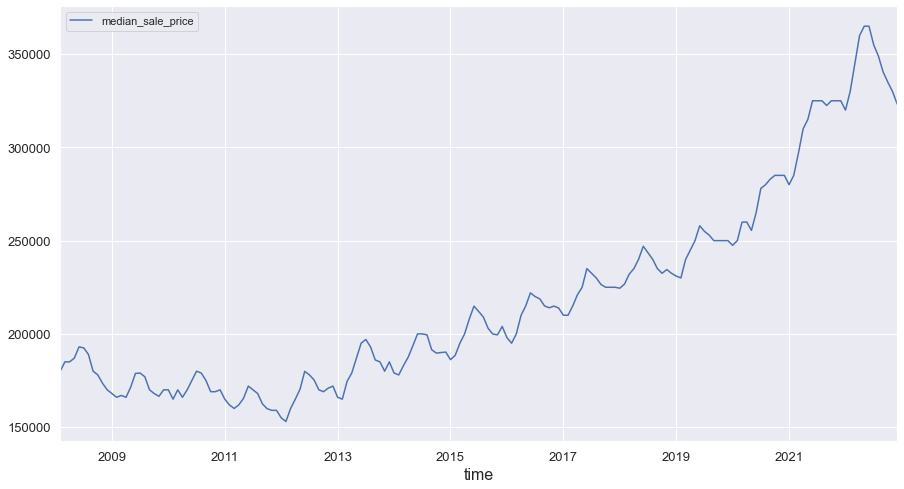

In [38]:
us_dfs[3].plot();

Unfortunately, I don't have data prior to 2018, but if we make the assumption that the other time series maintained a consistent seasonal pattern from 2012-2018, then it may be possible to perform a multivariate time series analysis, which could yield additional insights.

In a similar fashion, it is possible that the deviations in other datasets could predict deviations in price, but in order to be useful, the deviations would need to occur ahead of the price change in a predictable time frame.

### Economic Conditions

Lastly, there are other economic and market conditions to consider. One which I will mention is the effect that interest rates have on the housing market. Below is the data on the effective interest rate in the US, which is set by Federal Reserve.

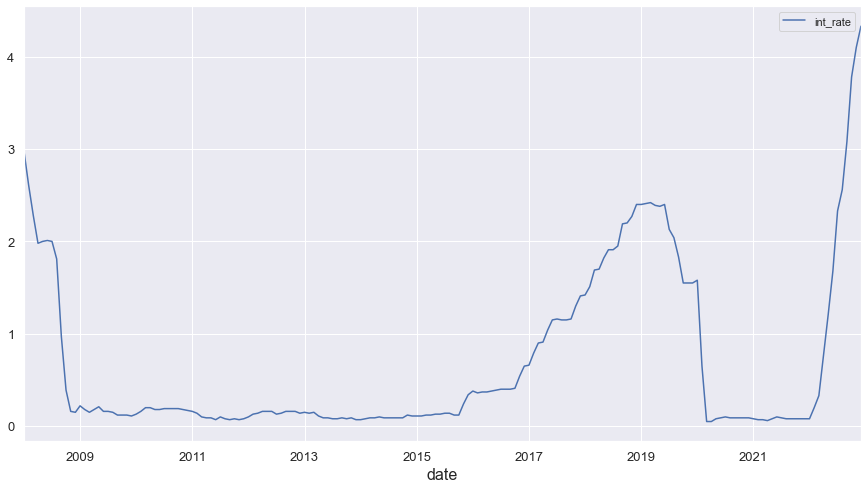

In [39]:
interest_rate = pd.read_csv('data/us_monthly_interest_rate.csv', index_col='DATE')
interest_rate.rename(columns={'FEDFUNDS':'int_rate'}, inplace=True)

us_int_rate = interest_rate['2008-02-01':]
# change datetime from beginning to end of month 
us_int_rate['date'] = pd.date_range("2008-01-31", freq="M", periods=180)
us_int_rate.set_index('date', inplace=True)

us_int_rate.plot();

The graph above shows the large drop in the interest rate following the 2008 housing crisis, followed by a long period of incredibly low rates. The interest rate was raised gradually from 2016-2019, but then quickly returned to zero during the global pandemic. It was during this period that housing price increases accelerated rapidly. And while the drop in interest rates in 2008 and 2020 do seem to have had their intended affects (market recovery in the case of 2008 and preventative market protection in the case of 2020), it is worth noting that from a statistical perspective, historical rates have little to no direct correlation with housing prices.

However, the drop in housing prices towards the end of 2022 is clearly, at least in part, a response to the Federal Reserves decision to quickly raise interest rates in an effort to combat inflation caused in part by the long period of little to no interest rates. Though it is impossible to predict what future actions the Federal Reserve will take, they have (at the time of writing this) publicly stated that they will continue to raise interest rates through 2023. This means that housing prices will likely remain suppressed for the next year.

These other sources of data and information will be important to consider along with the time series analysis performed previously.